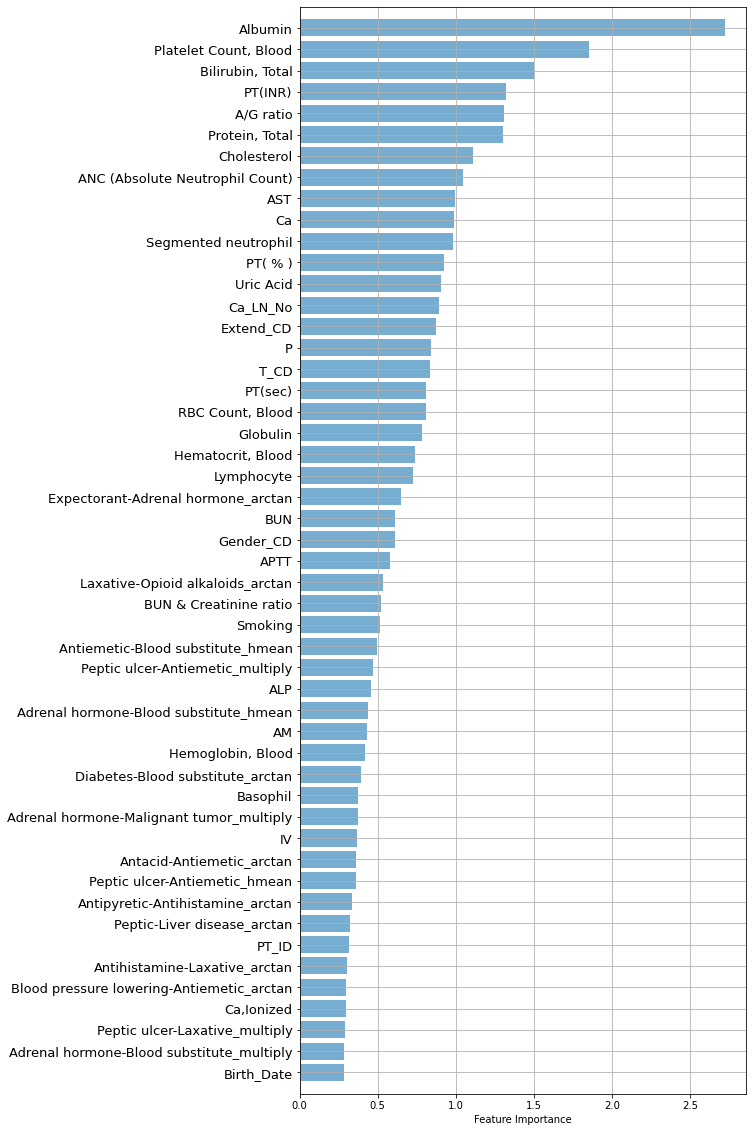

In [26]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import joblib
import shap
import warnings
warnings.filterwarnings(action='ignore')
np.random.seed(123)
random.seed(123)

data_df = pd.read_csv("preprocessed_data(dummy)/EHRs_DrugRel_Lab.csv")
data_df= data_df.drop(["Sepsis_Date"],axis=1)
padding = pd.DataFrame(0*np.ones((len(data_df), 1742-len(data_df.columns)-1)))
data_df = pd.concat([data_df,padding],axis=1)
data_feature = data_df.drop(["Label"], axis=1)
data_label = data_df[["Label"]]
columns=pd.read_csv("preprocessed_data(dummy)/features.csv")

scaler = joblib.load("trained_model/EHRs_DrugRel_Lab_scaler.pkl")
data_feature=scaler.transform(data_feature)
data_feature=pd.DataFrame(columns=list(columns.features.values), data=data_feature)
samples = data_feature

model = joblib.load("trained_model/EHRs_DrugRel_Lab_rf.pkl")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(samples, approximate=False, check_additivity=False)

def make_shap_waterfall_plot(shap_values, features, num_display=50):
    column_list = features.columns
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]
    
    num_height = 0
    if (num_display >= num_display) & (len(column_list) >= num_display):
        num_height = (len(column_list) - 20) * 0.4
        
    fig, ax1 = plt.subplots(figsize=(8, 8 + num_height))
    ax1.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.6)
    ax1.grid(True)
    ax1.set_xlabel('Feature Importance')
    ax1.tick_params(axis="y", labelsize=13)
    plt.ylim(-1, len(column_list))
    
    return column_list

columns=make_shap_waterfall_plot(shap_values[1], samples)